## Fig. 1 panel L heatmap

Prerequisite: Please run the notebooks in the enrichment folder first

In [1]:
import os
import sys
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')
plt.rcParams['pdf.fonttype'] = 42
import seaborn as sns

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))

from utils.label_processing import attach_annotations

### Load the volcano table

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")

Timestamp: 2024-07-14


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent / "enrichment"
volcano_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f"{timestamp}_volcano_table.csv"

try:
    # load the file
    volcano = pd.read_csv(volcano_csv_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {volcano_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {volcano_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# attach canonical gene names
gene_name_csv = data_path / "external" / "canonical_names_and_Itzhak_data.csv"

lookup_table = pd.read_csv(gene_name_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["Gene_name_canonical"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Majority protein IDs", to_on="Majority protein IDs")
    volcano[("metadata", "Gene_name_canonical")] = new_col_data

# attach ground truth
ground_truth_csv = data_path / "external" / "curated_ground_truth_v9.0.csv"

lookup_table = pd.read_csv(ground_truth_csv)
to_df = volcano["metadata"].copy()
list_of_cols_to_add = reversed(["compartment"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="gene_name_canonical", to_on="Gene_name_canonical")
    volcano[("metadata", "curated_ground_truth_v9.0")] = new_col_data


In [5]:
# define output directory
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Split the pvals and enrichments into two dataframes

In [6]:
sample_cols = [i for i in volcano.columns if i[0].startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))]

In [7]:
pval = volcano.copy()
for col in sample_cols:
    if col[1] == "enrichment":
        pval.drop(col, axis=1, inplace=True)

In [8]:
# construct a p-value dataframe
pval = volcano.copy()
for col in sample_cols:
    if col[1] == "enrichment":
        pval.drop(col, axis=1, inplace=True)

# rename the columns so that pval becomes the sample name (prepare for level drop)
new_column_names = [(i[0], i[0]) if i[1] == "pvals" else (i[0], i[1]) for i in pval.columns]
pval.columns = pd.MultiIndex.from_tuples(new_column_names)
pval = pval.droplevel(0, axis=1)

# construct an enrichment dataframe
enrichment = volcano.copy()
for col in sample_cols:
    if col[1] == "pvals":
        enrichment.drop(col, axis=1, inplace=True)

# rename the columns so that enrichment becomes the sample name (prepare for level drop)
new_column_names = [
    (i[0], i[0]) if i[1] == "enrichment" else (i[0], i[1]) for i in enrichment.columns
]
enrichment.columns = pd.MultiIndex.from_tuples(new_column_names)
enrichment = enrichment.droplevel(0, axis=1)

In [9]:
# drop WT columns

for col in enrichment.columns:
    if "WT" in col:
        enrichment.drop(col, axis=1, inplace=True)
        pval.drop(col, axis=1, inplace=True)

In [10]:
enrichment

,Protein IDs,Majority protein IDs,Gene names,13-RAB7A,12-RTN4,13-RAB14,12-SEC61B,12-TOMM20,12-PNPLA2,12-ACTB,...,11-EEA1,09-HSP90AA1,09-ATG101,10-TOMM20,09-PSMB7,10-EXOC2,09-EDC4,10-VPS35,Gene_name_canonical,curated_ground_truth_v9.0
0,A0A023T6R1;Q96A72;F5H6P7;F5H6N1;F5H3U9;F5H124,A0A023T6R1;Q96A72;F5H6P7;F5H6N1,FLJ10292;MAGOHB,0.926145,-0.089457,0.277650,-0.486730,-0.736898,0.594597,-0.179236,...,0.281842,-0.669259,2.692774,-0.589472,-1.432714,-0.492929,2.342249,-0.812759,MAGOHB,NaN
1,Q9Y5S9;A0A023T787;A0A0J9YW13,Q9Y5S9;A0A023T787,RBM8A;RBM8,-1.335100,-2.264500,-0.898950,-0.623300,-2.246100,0.710800,0.860750,...,-1.618800,-2.443700,-0.728450,-2.969400,-0.327100,1.017250,1.614550,-0.959200,RBM8A,NaN
2,A0A0C4DFM1;A0A024QYR3;Q92544;B4DH88;B4DKC1;Q6Z...,A0A0C4DFM1;A0A024QYR3;Q92544;B4DH88;B4DKC1;Q6ZTK5,TM9SF4,5.032826,4.511831,4.840405,4.783531,-0.436809,-4.775289,-4.635126,...,-1.672800,-5.702337,2.393000,-2.685600,-4.585382,-4.497900,-0.149000,0.601500,TM9SF4,Golgi
3,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,PTEN,1.142212,0.064925,-0.376243,0.447371,-0.030686,-0.429486,0.329705,...,-0.058161,-0.240339,-0.381822,0.105317,-0.704127,-1.008054,-0.449829,-0.567424,PTEN,NaN
4,Q99805;A0A024QYR8;B3KSG9,Q99805;A0A024QYR8;B3KSG9,TM9SF2,8.977542,6.673675,7.638707,6.847375,-2.183857,-7.775508,-5.963207,...,2.055000,-3.389100,-0.412350,-2.382900,-1.587400,0.033350,-1.223000,2.271100,TM9SF2,Golgi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,X5D7P8,X5D7P8,STK39,0.660475,-1.063275,0.342780,-0.251286,1.136048,0.383908,-0.365514,...,0.510393,-0.336893,1.261714,0.403811,-0.676353,-0.282873,0.652653,0.134485,STK39,NaN
8595,X5D8X9,X5D8X9,CNTNAP2,0.064876,-1.042621,0.963853,-0.715858,-0.678593,-0.153141,-0.061779,...,1.111325,0.370447,1.109283,-0.427328,-0.901160,-1.289691,0.822587,-1.054068,CNTNAP2,NaN
8596,X5DQV1;X5DNI1;B3KV96;E9PD68;B3KXQ5;Q14194;B3KT...,X5DQV1;X5DNI1;B3KV96;E9PD68;B3KXQ5;Q14194;B3KT...,CRMP1,-0.581294,0.320812,-0.496372,-0.355636,0.627502,0.130662,0.126567,...,0.332849,0.930923,-0.775370,-0.122160,-0.392848,0.632196,0.264631,-0.684204,CRMP1,NaN
8597,X5DQZ7,X5DQZ7,GPX1,-0.664371,-0.571915,-0.755153,-0.186079,1.974409,-0.646730,0.180603,...,-0.387396,4.146166,-0.635694,3.143259,0.161044,0.166296,-0.071422,0.622688,GPX1,NaN


### For insignificant p-vals convert the enrichment value to 0

In [11]:
samples = sorted([i for i in enrichment.columns if i.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")) and "WT" not in i])

In [12]:
-np.log10(0.05)

1.3010299956639813

In [13]:
enrichment_masked = enrichment.copy()

# uncomment the following lines to enable p-value filtering and negative enrichment filtering

# for col in samples:
#     mask = pval[col] < 1.301  # set the values to 0 if pval > 0.05
#     enrichment_masked.loc[mask, col] = 0  # set the values to NA if pval > 0.05

#     mask2 = enrichment[col] < 0
#     enrichment_masked.loc[mask2, col] = 0  # set the values to 0 if enrichment < 0

### Subset the dataframe to only include ground truth genes

In [14]:
# subset the umap table to remove rows with nan values in the ground truth labels
def subset_df(df):
    assert "curated_ground_truth_v9.0" in df.columns, "organelle column not found"

    # convert organelle labels to integers
    unique_strings = list(set(df["curated_ground_truth_v9.0"]))  # Get unique strings
    str_to_int_mapping = {string: index for index, string in enumerate(unique_strings)}  # Create a mapping from strings to unique integers
    org_label_data = [
        str_to_int_mapping[s] if not pd.isna(s) else s
        for s in df["curated_ground_truth_v9.0"]
    ]  # Convert the list of strings to a list of integers
    org_GT = np.array(org_label_data)

    # get non-NAN indices
    org_GT_non_nan_idx = np.nonzero(~np.isnan(org_GT))[0]

    # subset the umap table to remove rows with nan values in the ground truth labels
    df_org_GT = df.iloc[list(org_GT_non_nan_idx)]

    return df_org_GT

In [15]:
enrich_org_GT = subset_df(enrichment_masked)
pval_org_GT = subset_df(pval)

### Get averaged enrichment values for each organelle

In [16]:
averaged_enrich_values = []
for i in sorted(samples):
    averaged_enrich_values.append(
        enrich_org_GT.groupby("curated_ground_truth_v9.0")[i].mean()
    )

co_enrich_df = pd.DataFrame(averaged_enrich_values)

### Plotting

In [17]:
co_enrich_df.columns

Index(['ER', 'ERGIC', 'Golgi', 'actin-binding_protein', 'centrosome',
       'cytosol', 'early_endosome', 'lysosome', 'mitochondria', 'nuclear_pore',
       'nucleus', 'p-body', 'peroxisome', 'plasma membrane', 'ribosome',
       'stress granule'],
      dtype='object', name='curated_ground_truth_v9.0')

In [18]:
# select a subset of samples
to_keep = [
    "05-EDC4",
    "15-LAMP1",
    "12-RTN4",
    "12-SEC61B",
    "12-TOMM20",
    # "14-COPE",
    "13-GOLGA2",
    "14-RAB11A",
    # "17-MAP1LC3B",
    "11-EEA1",
    "09-PEX3",
    "17-SLC30A2",
    "17-G3BP1",
    "17-RPL36",
]
co_enrich_df = co_enrich_df.loc[to_keep, :]

# select a subset of compartments and enforce order
orgs = [
    "ribosome",
    "stress granule",
    "p-body",
    "plasma membrane",
    "early_endosome",
    "lysosome",
    "Golgi",
    # "ERGIC",
    "ER",
    "peroxisome",
    "mitochondria",
]

co_enrich_df = co_enrich_df[orgs]

In [19]:
# for each sample, get the strongest co-enriching organelle
maxes = {}
for i in co_enrich_df.index:
    maxes[i] = co_enrich_df.loc[i].idxmax()

# determine the sample order
# go through the organelles and find the sample with the highest co-enrichment value
sample_order = []
for o in orgs:
    for k, v in maxes.items():
        if v == o:
            sample_order.append(k)

# check the order
sample_order

['17-RPL36',
 '17-G3BP1',
 '05-EDC4',
 '17-SLC30A2',
 '11-EEA1',
 '15-LAMP1',
 '13-GOLGA2',
 '14-RAB11A',
 '09-PEX3',
 '12-RTN4',
 '12-SEC61B',
 '12-TOMM20']

In [20]:
# reposition 09-PEX3
pex3 = sample_order.pop(8)
sample_order.insert(10, pex3)
# check sample order
sample_order

['17-RPL36',
 '17-G3BP1',
 '05-EDC4',
 '17-SLC30A2',
 '11-EEA1',
 '15-LAMP1',
 '13-GOLGA2',
 '14-RAB11A',
 '12-RTN4',
 '12-SEC61B',
 '09-PEX3',
 '12-TOMM20']

In [21]:
#apply order of samples
df_plot = co_enrich_df[orgs]
df_plot = df_plot.loc[sample_order]

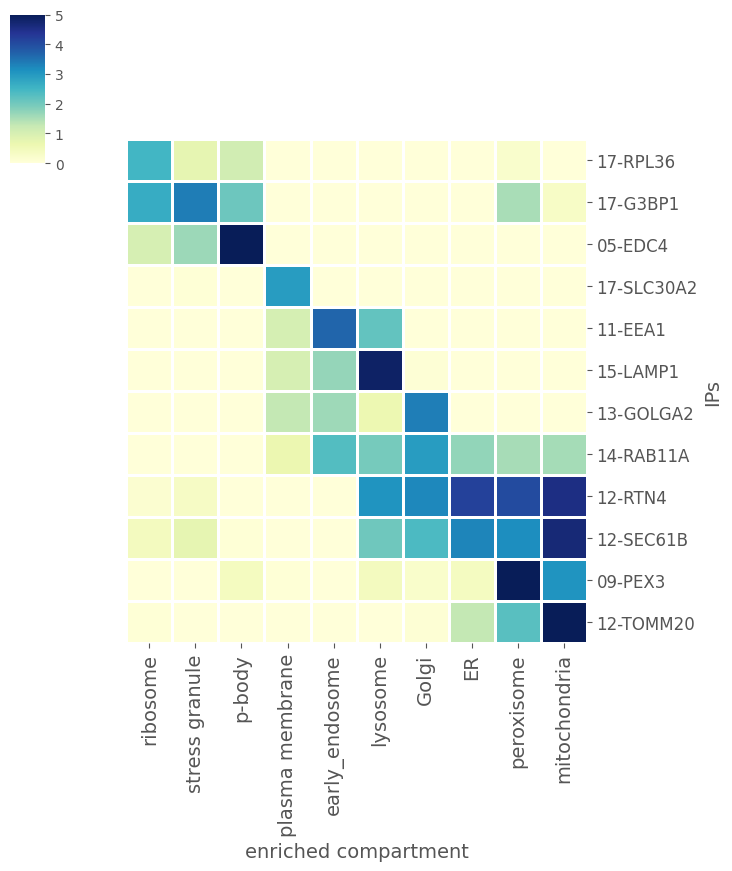

In [22]:
df_plot.fillna(0, inplace=True)
g = sns.clustermap(
    df_plot,
    figsize=(7, 8.25), col_cluster=False, row_cluster=False, standard_scale=None,
    #z_score=0,  # 0 means row-wise z-score,
    vmax = 5, # clip values above 5
    vmin = 0, # clip values below 0
    cmap="YlGnBu", linecolor="white", linewidths=2,
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=14)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=12)
g.ax_heatmap.set_xlabel("enriched compartment", fontsize=14)
g.ax_heatmap.set_ylabel("IPs", fontsize=14)

plt.savefig(os.path.join(output_dir, "co-enrichment.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(output_dir, "co-enrichment.svg"), bbox_inches="tight")